<a href="https://colab.research.google.com/github/aulphin/S-GuISE/blob/main/CAM_Metrics_And_Tuning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Part is Grad-cam upto Saliency Map generation successfully executed

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project/pytorch-grad-cam-master

/content/drive/MyDrive/Colab Notebooks/Folder/pytorch-grad-cam-master


In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/Folder/New-project/pytorch-grad-cam-master

In [ ]:
# %cd /content/drive/MyDrive/New-Project/pytorch-grad-cam-master  # Rjarohi id access

In [3]:
!pip install ttach

In [4]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

Execution on GradCAM Method

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


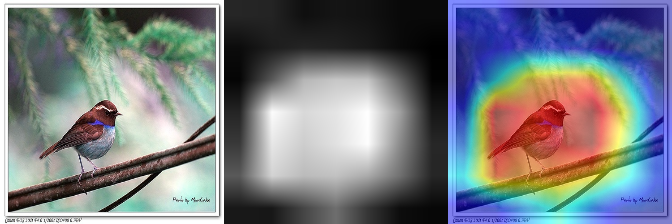

In [5]:

model = models.resnet50(pretrained=True)
model.eval()

#image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
#image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
#img = np.array(Image.open(requests.get(image_url, stream=True).raw))

#img_path = "/content/drive/MyDrive/Colab Notebooks/New-Project/000122.jpg"
img_path = "/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000236.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.

targets = [ClassifierOutputTarget(16)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))

Image.fromarray(images)

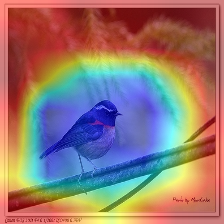

In [6]:
from google.colab.patches import cv2_imshow
#images = np.hstack([cam_image])

# Display the result in Google Colab
cv2_imshow(cam_image)

Compute Insertion and deletion metrics

In [7]:
# give the path of your file
%cd /content/drive/MyDrive/Colab Notebooks/New-Project

/content/drive/MyDrive/Colab Notebooks/New-Project


In [8]:

###### Importing libraries##########
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
cudnn.benchmark = True

In [9]:
from evaluation import CausalMetric, auc, gkern
from utils import *

In [10]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

# To use multiple GPUs
#model = nn.DataParallel(model)

In [11]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

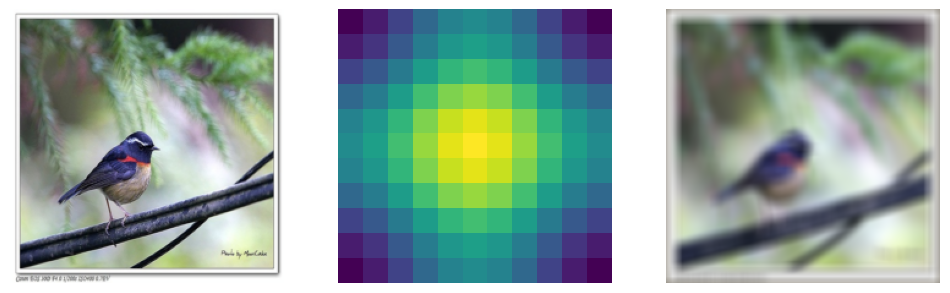

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor("/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages/000236.jpg")
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [13]:
######### Causal Metrics #######
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

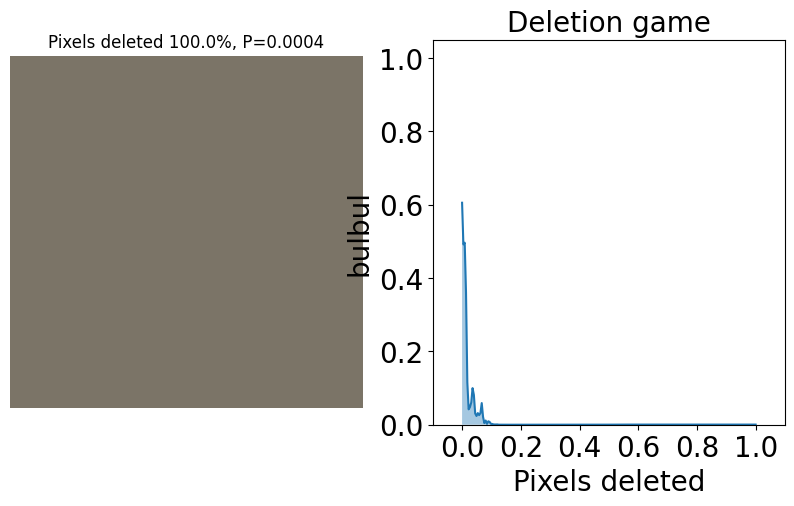

AUC: 0.010762765391134823


In [14]:
h = deletion.single_run(img, images, verbose=1)

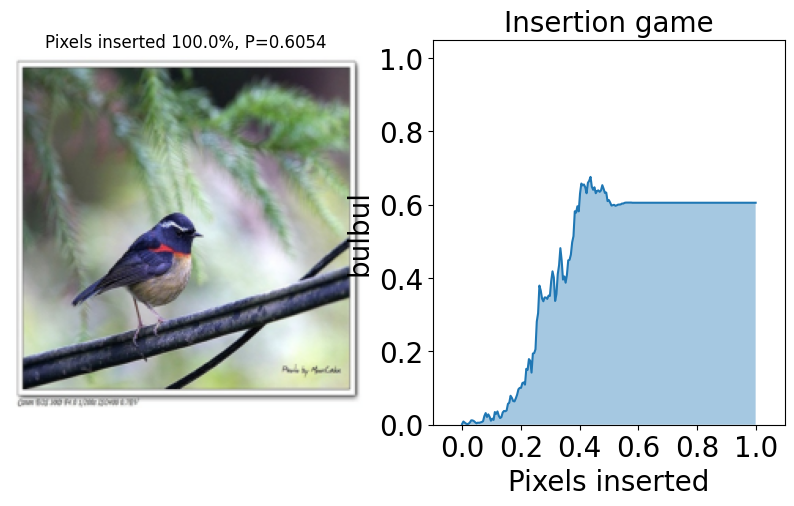

AUC: 0.44257239720224917


In [15]:
h = insertion.single_run(img, images, verbose=1)

##################### upto this ################# Grad cam #######